# Változó számának csökkentése, változó kiválasztás

## F1/a - normál eloszlású változók generálása

In [1]:
import pandas as pd
import numpy as np

In [2]:
np.random.seed(42)
def get_random_data(n_random_var, n_rows):

    fake_df = pd.DataFrame()
    
    fake_data_dict = {} # to avoid 'DataFrame is highly fragmented' warning coming from appending many columns 1 by 1 

    mu, sigma = 0, 1 # mean and standard deviation
    for i in range(n_random_var):
        fake_data_dict[f'rand_norm_{i}'] = np.random.normal(mu, sigma, n_rows)

    fake_df = pd.DataFrame(fake_data_dict)
    fake_df['target'] = [ind%2 for ind in fake_df.index]
    
    return fake_df

fake_df = get_random_data(n_random_var=1000, n_rows=1797)

## F1/b - Dimenziók átkának demonstrációja

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

train_df, test_df = train_test_split(fake_df, test_size=0.2, random_state=42)

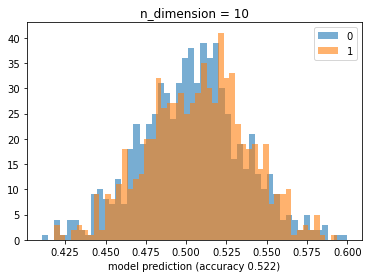

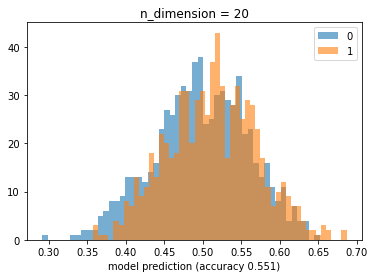

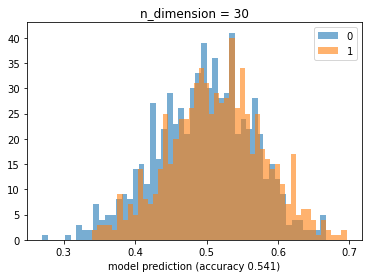

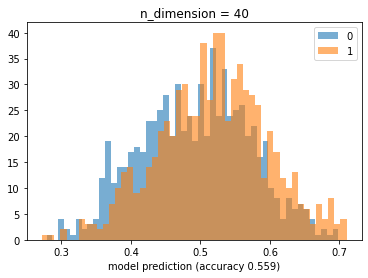

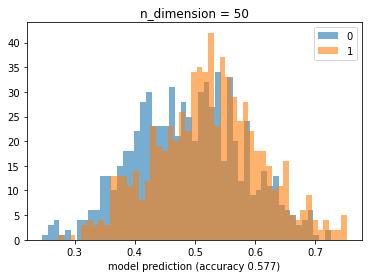

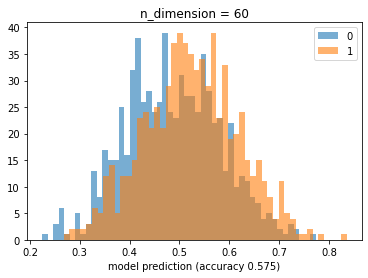

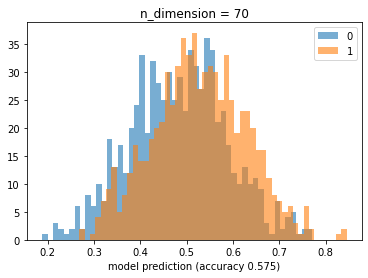

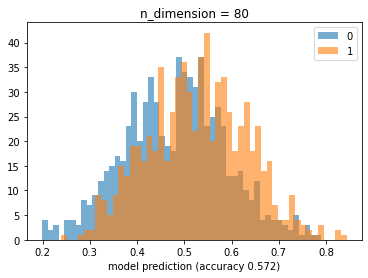

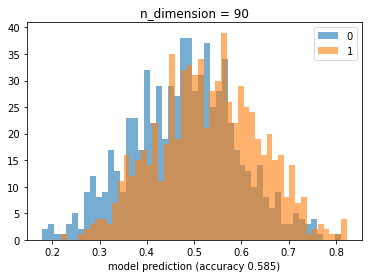

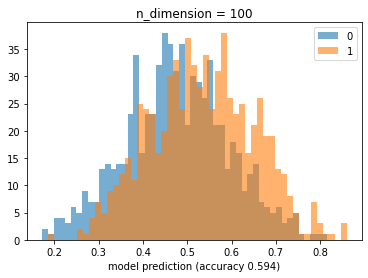

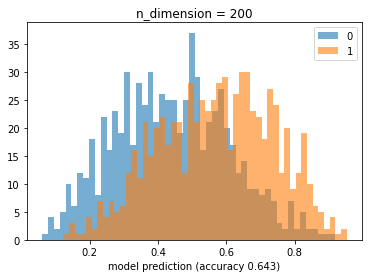

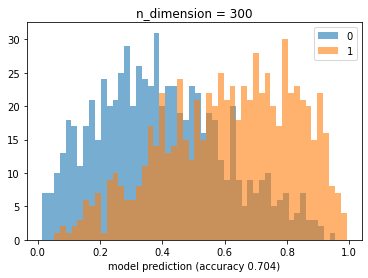

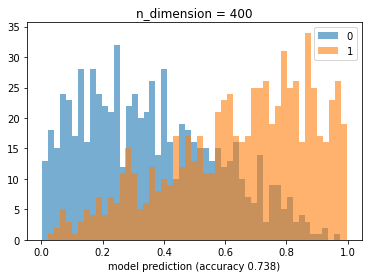

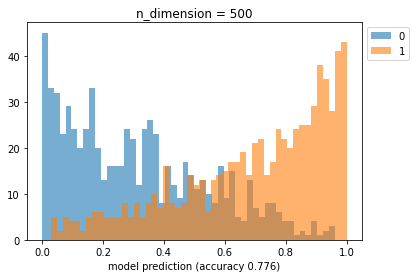

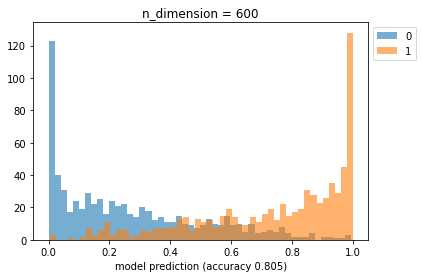

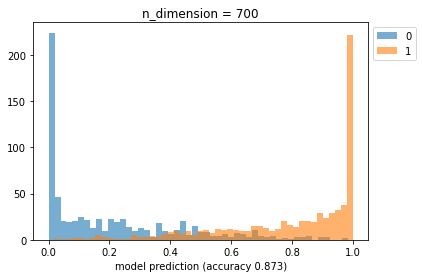

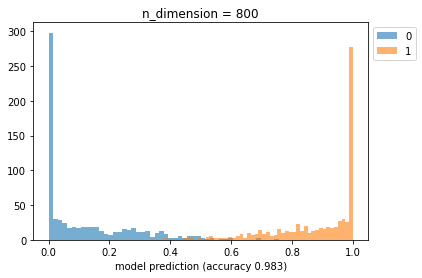

In [4]:
model = LogisticRegression()
for n_dimension in list(range(10,100,10))+list(range(100,801,100)):

    train_w_N_dim = train_df.iloc[:, :n_dimension].copy()
    model.fit(train_w_N_dim, train_df['target'])
    train_w_N_dim.loc[:, 'pred_prob'] = model.predict_proba(train_w_N_dim.iloc[:,:n_dimension])[:,1]
    train_w_N_dim.loc[:, 'pred'] = model.predict(train_w_N_dim.iloc[:,:n_dimension])
    
    for group in [0,1]:
        plt.hist(train_w_N_dim.loc[train_df['target']==group, 'pred_prob'],
                   label=group, alpha=0.6, bins=50)
        plt.legend(bbox_to_anchor=(1, 1))
    acc = round(accuracy_score(train_df['target'], train_w_N_dim['pred']),3)
    plt.xlabel(f'model prediction (accuracy {acc})')
    plt.title(f'n_dimension = {n_dimension}') # .set_title('Axis [0, 0]')
    plt.show()

In [5]:
model.fit(train_df.iloc[:,:-1], train_df['target'])
accuracy_score(train_df['target'], model.predict(train_df.iloc[:,:-1]))

1.0

In [6]:
accuracy_score(test_df['target'], model.predict(test_df.iloc[:,:-1]))

0.4888888888888889

### F2 -  Mi lenne ha - a lehetséges kombinációk számának megértése / megérzése
Tegyük fel hogy:
- Egy tanítási és tesztelési, kiértékelési ciklus 10ms alatt lefut
- Rendelkezésünkre áll Magyarország összes számítógépe, mondjuk 10 millió számítógép 
- A 64 elemű változólistából minden kombinációt ki akarunk próbálni, kivéve azt, amikor az összes elemet kizárjuk a bemeneti változók közül.

__KÉRDÉS__: Mennyi ideig tartana kipróbálni az összes lehetséges kombinációt ennyi gépen?

In [7]:
verziok_szama=2**64-1

masodpercenkenti_modell_epites_es_kiertekeles = 1000/10
szamitogepek_szama = 10**7
egygepen=verziok_szama/szamitogepek_szama
ido_mp = egygepen/masodpercenkenti_modell_epites_es_kiertekeles
ido_perc=ido_mp/60
ido_ora =ido_perc/60
ido_nap =ido_ora/24
ido_ev = ido_nap/365
ido_ev

584.9424173550719

## F3 - változókiválasztási módszerek összevetéséhez summary baseline-nal

In [8]:
from sklearn.datasets import load_digits

digits=load_digits(as_frame=True)
X = digits.data
y = digits.target

In [9]:
X.head(2)

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0


In [10]:
from sklearn.metrics import log_loss, roc_auc_score

In [11]:
def add_to_summary(summary, X_train, X_test, y_train, y_test, method, model):
    model.fit(X_train, y_train)

    summary.loc[method, 'Logloss - train'] = log_loss(y_train, model.predict_proba(X_train))
    summary.loc[method, 'Logloss - test'] = log_loss(y_test, model.predict_proba(X_test))
    summary.loc[method, 'n_features'] = len(X_train.columns)
    summary.loc[method, 'features'] = list(X_train.columns)
    print(summary.loc[method])

    return summary, model

summary = pd.DataFrame(columns=['Logloss - train', 'Logloss - test', 'n_features', 'features'])

In [12]:
print(X.dtypes.value_counts())

float64    64
dtype: int64


In [13]:
X.columns[X.isnull().sum()!=0]

Index([], dtype='object')

In [14]:
model = LogisticRegression(max_iter=10000) # Avoid 'ConvergenceWarning: lbfgs failed to converge'

y = digits.target == 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

summary, trained_model = add_to_summary(summary, X_train, X_test, y_train, y_test, method = 'baseline', model=model)

Logloss - train                                             0.005157
Logloss - test                                               0.10543
n_features                                                        64
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: baseline, dtype: object


In [15]:
from random import sample
from random import seed
seed(42)
example = [1,2,3,4]
sample(example,2)

[1, 4]

In [16]:
seed(42)
subset32=sample(list(X_train.columns),32)

In [17]:
summary, trained_model = add_to_summary(summary, X_train[subset32], X_test[subset32], y_train, y_test, method = 'random32', model=model)

Logloss - train                                             0.085303
Logloss - test                                              0.117529
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object


In [18]:
summary

,Logloss - train,Logloss - test,n_features,features
baseline,0.005157,0.10543,64,"[pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p..."
random32,0.085303,0.117529,32,"[pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p..."


Egy tanítási-tesztelési ciklus idejének lemérése a %timeit paranccsal

In [19]:
%timeit add_to_summary(summary, X_train[subset32], X_test[subset32], y_train, y_test, method = 'random32', model=model)

Logloss - train                                             0.085303
Logloss - test                                              0.117529
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object
Logloss - train                                             0.085303
Logloss - test                                              0.117529
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object
Logloss - train                                             0.085303
Logloss - test                                              0.117529
n_features                                                        32
features           [pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p...
Name: random32, dtype: object
Logloss - train                                             0.085303
Logloss - tes

### Dimenziók átkának megjelenése az adott adathalmaznál

In [20]:
X_train_with_rnd = X_train.join(fake_df.drop('target', axis=1), how='left')
X_test_with_rnd = X_test.join(fake_df.drop('target', axis=1), how='left')

model = LogisticRegression(max_iter=1000, random_state=42, C=10000) # Avoid 'ConvergenceWarning: lbfgs failed to converge'
summary, trained_model = add_to_summary(summary, X_train_with_rnd, X_test_with_rnd, y_train, y_test, method='dim_atok', model=model)


Logloss - train                                                  0.0
Logloss - test                                              0.140416
n_features                                                      1064
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: dim_atok, dtype: object


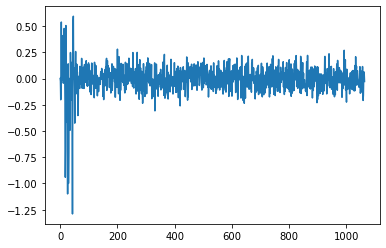

In [21]:
plt.plot(trained_model.coef_[0]);

## F4 - Korreláció alapú szelekció

In [22]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_predict

In [23]:
model = LogisticRegression(max_iter=1000, random_state=42)
corrs_to_y = abs(pd.concat([X_train, y_train], axis=1).corr()['target']).sort_values(ascending=False)
corrs_to_y = corrs_to_y.drop('target')
corrs_to_y

pixel_3_2    0.426025
pixel_4_2    0.360612
pixel_2_2    0.354472
pixel_5_3    0.325953
pixel_2_4    0.278792
               ...   
pixel_7_0    0.009734
pixel_1_6    0.006150
pixel_0_0         NaN
pixel_4_0         NaN
pixel_4_7         NaN
Name: target, Length: 64, dtype: float64

100%|██████████| 64/64 [00:33<00:00,  1.93it/s]


Logloss - train                                             0.029872
Logloss - test                                              0.058009
n_features                                                        24
features           [pixel_3_2, pixel_4_2, pixel_2_2, pixel_5_3, p...
Name: top-corr, dtype: object


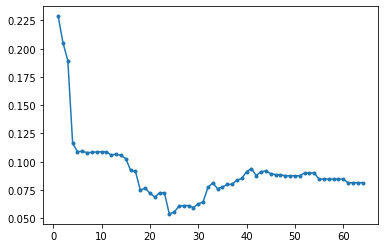

In [24]:
corr_based_topX = pd.DataFrame()

for top_x in tqdm(range(1, len(X.columns)+1)):

    # kivalasztjuk elso X legjobban korrelalo valtozot
    selected_vars = [item for item in corrs_to_y[:top_x].index]
    pred_proba = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:,1]
    corr_based_topX.loc[top_x, 'Logloss'] = log_loss(y_train, pred_proba)

corr_based_topX['Logloss'].plot(marker='.')

best_n_features_based_on_logloss = corr_based_topX['Logloss'].idxmin()
selected_vars = [item for item in corrs_to_y[:best_n_features_based_on_logloss].index if item!='y']
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method='top-corr', model=model)

In [25]:
corr_based_topX['Logloss'].min()

0.05386821511796415

## F5 - Forward selection módszere

In [26]:
model = LogisticRegression(max_iter=1000, random_state=42)

### A) ELSŐ ESET: Manual

In [27]:
kivalasztott_valtozok=[]
meg_nem_kivalasztottak=list(X_train.columns)
best_logloss_list=[]
best_logloss = 9999999999
for elemszam in tqdm(range(0,len(X_train.columns))):
    best_var = ""
    for v in (meg_nem_kivalasztottak):
        used_features = kivalasztott_valtozok + [v]
        pred = cross_val_predict(model, X_train[used_features], y_train, cv=4, method='predict_proba')
        logloss = log_loss(y_train, pred)
        if logloss<best_logloss:
            best_var = v
            best_logloss=logloss
            # print("\tValaki jobb: ", best_var, best_logloss)
    if best_var!="":
        meg_nem_kivalasztottak.remove(best_var)
        kivalasztott_valtozok.append(best_var)
        best_logloss_list.append(best_logloss)
        print(kivalasztott_valtozok,best_logloss)
    else:
        print(f"\n FINISHED because there is no progress by adding any of the followings: {meg_nem_kivalasztottak}")
        break

  2%|▏         | 1/64 [00:03<03:12,  3.06s/it]

['pixel_3_2'] 0.2287135045745418


  3%|▎         | 2/64 [00:06<03:20,  3.23s/it]

['pixel_3_2', 'pixel_5_3'] 0.1349611860273731


  5%|▍         | 3/64 [00:09<03:26,  3.38s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6'] 0.0962278905433502


  6%|▋         | 4/64 [00:13<03:37,  3.62s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4'] 0.08204673998952368


  8%|▊         | 5/64 [00:18<03:56,  4.00s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6'] 0.07134283727341201


  9%|▉         | 6/64 [00:23<04:06,  4.26s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6'] 0.06379350167144526


 11%|█         | 7/64 [00:28<04:15,  4.47s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5'] 0.05656123367961775


 12%|█▎        | 8/64 [00:33<04:23,  4.70s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2'] 0.04821260735574001


 14%|█▍        | 9/64 [00:38<04:29,  4.90s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2'] 0.044316776178477506


 16%|█▌        | 10/64 [00:44<04:36,  5.12s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5'] 0.04066960810189339


 17%|█▋        | 11/64 [00:51<05:04,  5.75s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4'] 0.03825122103450994


 19%|█▉        | 12/64 [00:59<05:27,  6.29s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5'] 0.03658986342542594


 20%|██        | 13/64 [01:08<06:00,  7.07s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6'] 0.035397322818302566


 22%|██▏       | 14/64 [01:17<06:26,  7.73s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3'] 0.03433535439893252


 23%|██▎       | 15/64 [01:26<06:43,  8.24s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1'] 0.03347052809504322


 25%|██▌       | 16/64 [01:39<07:38,  9.55s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7'] 0.033443859183640574


 27%|██▋       | 17/64 [01:52<08:17, 10.58s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6'] 0.03322178708913312


 28%|██▊       | 18/64 [02:05<08:49, 11.51s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6', 'pixel_1_4'] 0.030580248248356423


 30%|██▉       | 19/64 [02:20<09:18, 12.42s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6', 'pixel_1_4', 'pixel_5_4'] 0.030124904064355664


 31%|███▏      | 20/64 [02:37<10:02, 13.68s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6', 'pixel_1_4', 'pixel_5_4', 'pixel_4_2'] 0.030017324760294787


 33%|███▎      | 21/64 [02:52<10:13, 14.28s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6', 'pixel_1_4', 'pixel_5_4', 'pixel_4_2', 'pixel_6_7'] 0.029485457062378203


 34%|███▍      | 22/64 [03:09<10:29, 15.00s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6', 'pixel_1_4', 'pixel_5_4', 'pixel_4_2', 'pixel_6_7', 'pixel_1_7'] 0.02946363809766391


 36%|███▌      | 23/64 [03:28<10:59, 16.08s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6', 'pixel_1_4', 'pixel_5_4', 'pixel_4_2', 'pixel_6_7', 'pixel_1_7', 'pixel_3_7'] 0.029463032581124555


 38%|███▊      | 24/64 [03:46<11:10, 16.77s/it]

['pixel_3_2', 'pixel_5_3', 'pixel_3_6', 'pixel_0_4', 'pixel_7_6', 'pixel_5_6', 'pixel_3_5', 'pixel_5_2', 'pixel_2_2', 'pixel_1_5', 'pixel_2_4', 'pixel_6_5', 'pixel_0_6', 'pixel_2_3', 'pixel_4_1', 'pixel_7_7', 'pixel_1_6', 'pixel_1_4', 'pixel_5_4', 'pixel_4_2', 'pixel_6_7', 'pixel_1_7', 'pixel_3_7', 'pixel_3_0'] 0.02946227783855187


 38%|███▊      | 24/64 [04:04<06:47, 10.20s/it]


 FINISHED because there is no progress by adding any of the followings: ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_5', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_2_0', 'pixel_2_1', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_1', 'pixel_3_3', 'pixel_3_4', 'pixel_4_0', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_5', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_6', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5']


In [28]:
summary, trained_model = add_to_summary(summary, X_train[kivalasztott_valtozok], X_test[kivalasztott_valtozok], y_train, y_test, method='manual-Forward', model=model)

Logloss - train                                             0.014867
Logloss - test                                              0.061981
n_features                                                        24
features           [pixel_3_2, pixel_5_3, pixel_3_6, pixel_0_4, p...
Name: manual-Forward, dtype: object


In [29]:
summary

,Logloss - train,Logloss - test,n_features,features
baseline,0.005157,0.10543,64,"[pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p..."
random32,0.085303,0.117529,32,"[pixel_1_6, pixel_0_1, pixel_5_7, pixel_2_1, p..."
dim_atok,0.0,0.140416,1064,"[pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p..."
top-corr,0.029872,0.058009,24,"[pixel_3_2, pixel_4_2, pixel_2_2, pixel_5_3, p..."
manual-Forward,0.014867,0.061981,24,"[pixel_3_2, pixel_5_3, pixel_3_6, pixel_0_4, p..."


### B) SequentialFeatureSelector fixált n_feature esetén

In [30]:
from sklearn.metrics import make_scorer
LogLoss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [31]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(model, n_features_to_select=len(kivalasztott_valtozok), scoring=LogLoss_scorer, cv=4, direction='forward')
sfs.fit(X_train, y_train)

cols_from_sfs = X_train.columns[sfs.get_support()]

In [32]:
print('eltérés a manual és implementált között:')
print(set(kivalasztott_valtozok) - (set(cols_from_sfs)))
print(set(cols_from_sfs) - (set(kivalasztott_valtozok)))

eltérés a manual és implementált között:
{'pixel_3_7'}
{'pixel_7_0'}


In [33]:
sfs.get_support()

array([False, False, False, False,  True, False,  True, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True,  True, False, False, False, False, False,  True,
        True])

## C) SequentialFeatureSelector auto n_feature esetén

In [34]:
from sklearn.feature_selection import SequentialFeatureSelector
from datetime import datetime as datetime
start = datetime.now()

sfs = SequentialFeatureSelector(model, n_features_to_select='auto', scoring=LogLoss_scorer,
                                cv=4, direction='forward', tol = 0.00000001)
sfs.fit(X_train, y_train)

cols_from_sfs = X_train.columns[sfs.get_support()]

time_spent = str(datetime.now()-start)
print(f'SFS time to found best n_features ({len(cols_from_sfs)}) : {time_spent} ')

SFS time to found best n_features (24) : 0:04:30.327556 


In [35]:
summary, trained_model = add_to_summary(summary, X_train[cols_from_sfs], X_test[cols_from_sfs], y_train, y_test, method='forward_sfs', model=model)

Logloss - train                                             0.014869
Logloss - test                                              0.061972
n_features                                                        24
features           [pixel_0_4, pixel_0_6, pixel_1_4, pixel_1_5, p...
Name: forward_sfs, dtype: object


## F6 - Recursive feature elimination (RFE)

In [36]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

min_features_to_select=1
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring=LogLoss_scorer,
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train.values, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 13


In [37]:
rfecv.cv_results_

{'mean_test_score': array([-0.2838157 , -0.227726  , -0.14726615, -0.10336098, -0.09662938,
        -0.0887756 , -0.08385171, -0.08118348, -0.07312421, -0.07659017,
        -0.07495662, -0.07281729, -0.06524953, -0.06810083, -0.07116892,
        -0.07267702, -0.07709821, -0.07572846, -0.07604509, -0.07983412,
        -0.08871646, -0.08895251, -0.0911337 , -0.08906746, -0.09132062,
        -0.0915651 , -0.09029093, -0.0902278 , -0.08731526, -0.08613741,
        -0.0861763 , -0.0893623 , -0.09229779, -0.09145976, -0.09096174,
        -0.09145342, -0.09024692, -0.08996508, -0.090836  , -0.09021211,
        -0.09124931, -0.09032692, -0.09017921, -0.08971197, -0.08992196,
        -0.08933743, -0.08910606, -0.08831876, -0.08843549, -0.08866187,
        -0.0886222 , -0.08850723, -0.0885076 , -0.0885244 , -0.08852516,
        -0.08851949, -0.08856114, -0.08851777, -0.08853687, -0.08854317,
        -0.08850531, -0.08852442, -0.08851948, -0.08851546]),
 'std_test_score': array([0.00708405, 0.043

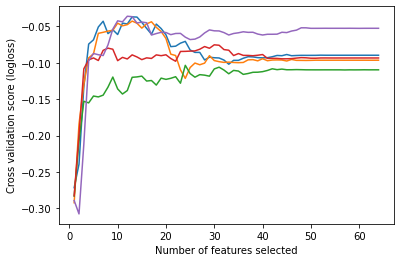

In [38]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (logloss)")
split_scores_names = [split_test_score for split_test_score in rfecv.cv_results_.keys() if split_test_score.startswith('split')]
for splitX_test_score in split_scores_names:
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_[splitX_test_score]) + min_features_to_select),
        rfecv.cv_results_[splitX_test_score],
    )
plt.show()

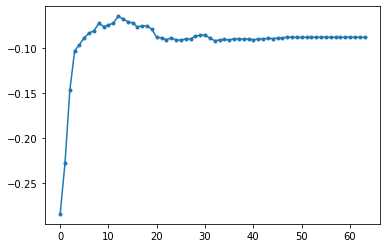

In [39]:
plt.plot(rfecv.cv_results_['mean_test_score'],marker='.')

In [40]:
RFECV_selected_vars = list(X_train.columns[rfecv.support_])
summary, trained_model = add_to_summary(summary, X_train[RFECV_selected_vars], X_test[RFECV_selected_vars], y_train, y_test, method='RFE', model=model)

Logloss - train                                             0.024403
Logloss - test                                              0.085965
n_features                                                        13
features           [pixel_0_4, pixel_1_2, pixel_1_4, pixel_1_6, p...
Name: RFE, dtype: object


## F7 - Model alapú megoldások - Logisztikus regresszió coeficiennsei 

<AxesSubplot:>

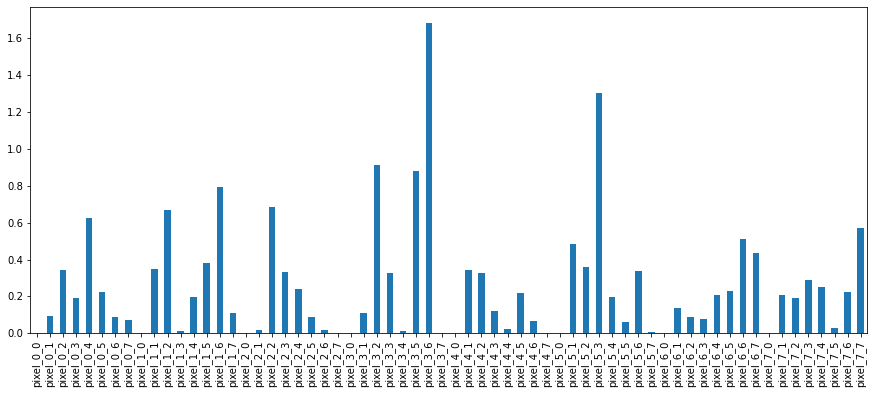

In [41]:
plt.rcParams["figure.figsize"] = (15,6)
model = LogisticRegression(max_iter=10000, random_state=42)

model.fit(X_train, y_train)

var_coefs = pd.Series(model.coef_[0], index=X_train.columns).apply(abs)
var_coefs.plot.bar()

100%|██████████| 64/64 [00:37<00:00,  1.70it/s]


<AxesSubplot:>

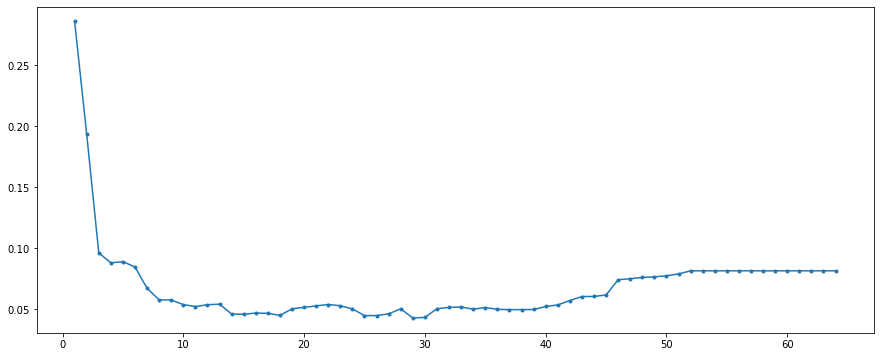

In [42]:
coef_based_topX = pd.DataFrame()
vars_sorted_by_coef = list(var_coefs.sort_values(ascending=False).index)
for top_x in tqdm(range(1, len(vars_sorted_by_coef)+1)):
    selected_vars = vars_sorted_by_coef[:top_x]
    pred_proba = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:,1]
    coef_based_topX.loc[top_x, 'Logloss'] = log_loss(y_train, pred_proba)

coef_based_topX['Logloss'].plot(marker='.')

In [43]:
best_n_features = coef_based_topX['Logloss'].idxmin()
selected_vars = vars_sorted_by_coef[:best_n_features]
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method=f'model_based_logreg', model=model)

Logloss - train                                             0.007637
Logloss - test                                              0.099536
n_features                                                        29
features           [pixel_3_6, pixel_5_3, pixel_3_2, pixel_3_5, p...
Name: model_based_logreg, dtype: object


## F8 - Változó kiválasztás lasso regresszió segítségével

$ célfüggvény = ModellHibájaAPontokon + \frac{1}{C}*ModellKomplexitás = ModellHibájaAPontokon + \frac{1}{C} * \sum_{i=1}^{m}|\alpha_i|$

In [44]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 5, 10, 25, 50, 100]

logloss_df = pd.DataFrame()
for C in tqdm(Cs):
    model_for_lasso = LogisticRegression(solver='saga', max_iter=1000, penalty='l1', C=C, random_state=42)
    pred_proba = cross_val_predict(model_for_lasso, X_train, y_train, cv=4, method='predict_proba')[:,1]
    logloss_df.loc[C, 'Logloss'] = log_loss(y_train, pred_proba)

    model_for_lasso.fit(X_train, y_train)
    selected_vars = list(X_train.columns[model_for_lasso.coef_[0]!=0])
    logloss_df.loc[C, 'selected_vars'] = [[selected_vars]]
    logloss_df.loc[C, 'n_selected_vars'] = len(selected_vars)

 15%|█▌        | 2/13 [00:12<01:10,  6.45s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 3/13 [00:22<01:22,  8.20s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages

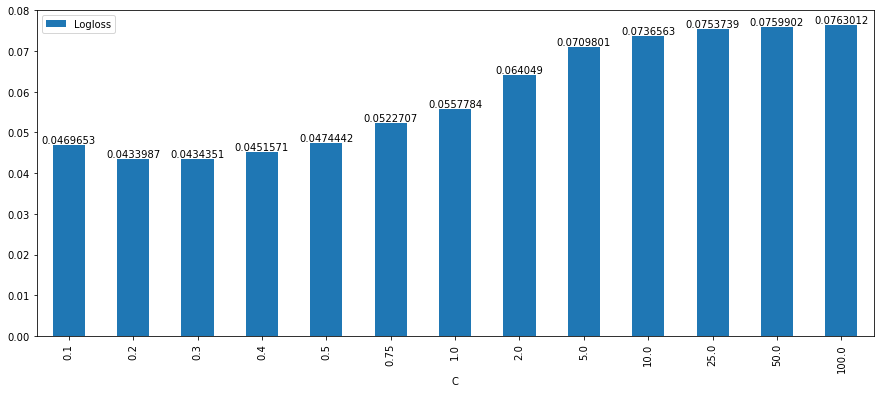

In [45]:
ax = logloss_df.reset_index().rename(columns = {'index':'C'}).plot.bar(x='C', y='Logloss')
ax.bar_label(ax.containers[0]);

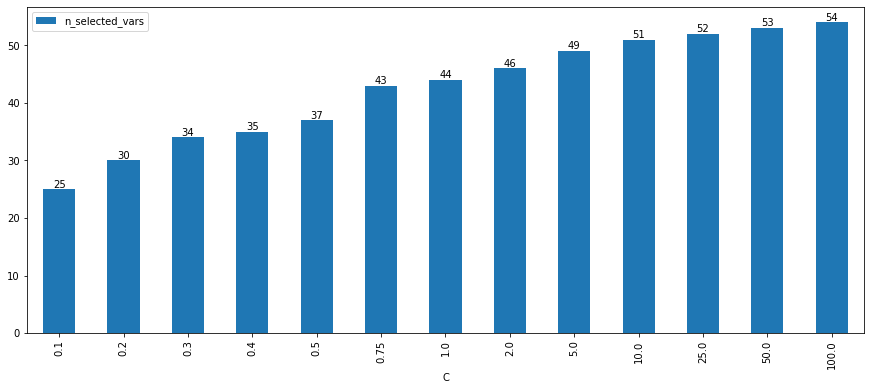

In [46]:
ax = logloss_df.reset_index().rename(columns = {'index':'C'}).plot.bar(x='C', y='n_selected_vars')
ax.bar_label(ax.containers[0]);

In [47]:
best_C = logloss_df['Logloss'].idxmin()
print(f'Best C is {best_C}')

selected_vars_for_best_C = logloss_df.loc[best_C, 'selected_vars']
selected_by_lasso = selected_vars_for_best_C[0]

model = LogisticRegression(max_iter=1000, random_state=42)
summary, model_trained = add_to_summary(summary, X_train[selected_by_lasso], X_test[selected_by_lasso], y_train, y_test, method=f'lasso', model=model)

Best C is 0.2
Logloss - train                                             0.007039
Logloss - test                                              0.099027
n_features                                                        30
features           [pixel_0_2, pixel_0_3, pixel_0_4, pixel_1_1, p...
Name: lasso, dtype: object



## F9 - model_based (gbm + feature_importance)

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=600, max_depth=3, random_state=42, learning_rate=0.1)
summary, trained_model = add_to_summary(summary, X_train, X_test, y_train, y_test, method = 'gbm_bl', model=gbm)
var_imps = pd.Series(trained_model.feature_importances_, index=X_train.columns)
n_of_vars_with_zero_importance = (var_imps==0).sum()
print(f'\nn features with zero importance = {n_of_vars_with_zero_importance}')

Logloss - train                                                  0.0
Logloss - test                                              0.066845
n_features                                                        64
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: gbm_bl, dtype: object

n features with zero importance = 14


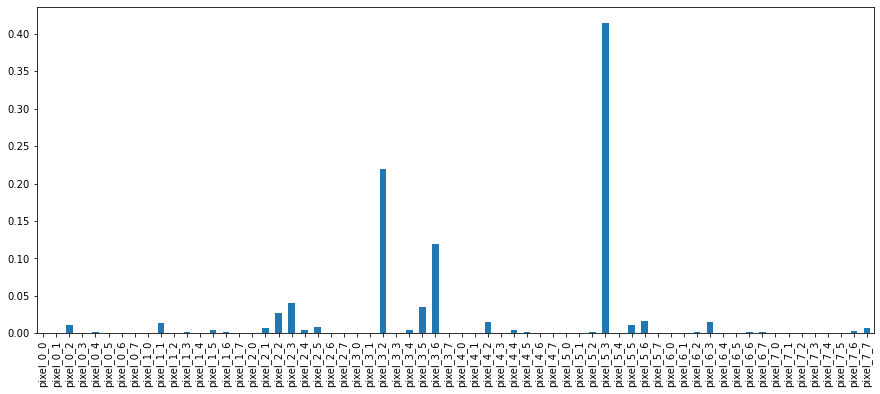

In [49]:
var_imps = pd.Series(trained_model.feature_importances_, index=X_train.columns)
var_imps.plot.bar()
plt.rcParams["figure.figsize"] = (20,10)

100%|██████████| 64/64 [09:19<00:00,  8.75s/it]


Logloss - train                                                  0.0
Logloss - test                                              0.065964
n_features                                                        27
features           [pixel_5_3, pixel_3_2, pixel_3_6, pixel_2_3, p...
Name: model_based_gbm, dtype: object


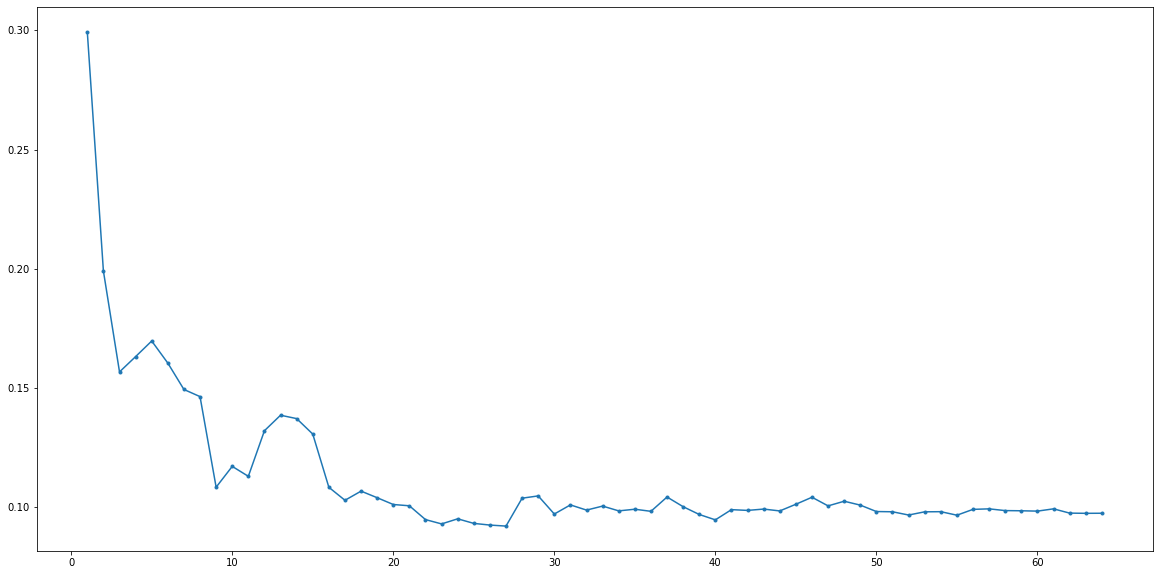

In [50]:
imp_based_topX = pd.DataFrame()
vars_sorted_by_imp = list(var_imps.sort_values(ascending=False).index)
for top_x in tqdm(range(1, len(vars_sorted_by_imp)+1)):
    selected_vars = vars_sorted_by_imp[:top_x]
    pred_proba = cross_val_predict(gbm, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:,1]
    imp_based_topX.loc[top_x, 'Logloss'] = log_loss(y_train, pred_proba)

imp_based_topX['Logloss'].plot(marker='.')

best_n_features = imp_based_topX['Logloss'].idxmin()
selected_vars = vars_sorted_by_imp[:best_n_features]
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method=f'model_based_gbm', model=gbm)

## F10 - melyik pixelt választják ki legtöbbször a különböző módszerek?

In [51]:
methods = ['top-corr', 'manual-Forward', 'RFE', 'model_based_logreg', 'model_based_gbm', 'lasso']
selected_vars_all = summary.loc[methods, 'features'].tolist()
falttened_selected_vars_all = [selected_feature for selected_features in selected_vars_all for selected_feature in selected_features]

In [52]:
selected_times={}
for pixel in X_train.columns:
    selected_times[pixel]=0

In [53]:
for used_pixel in falttened_selected_vars_all:
    selected_times[used_pixel]=selected_times[used_pixel]+1

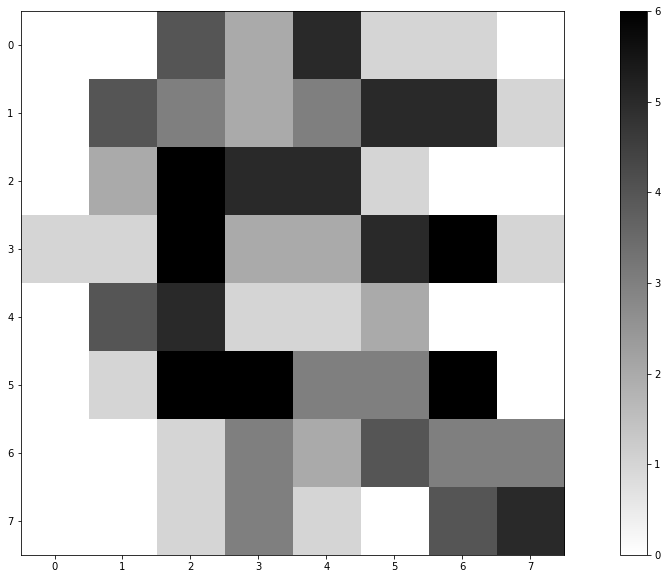

In [54]:
plt.imshow(np.array(list(selected_times.values())).reshape(8, 8), cmap='gray_r')
plt.colorbar()

In [55]:
[i for i in selected_times.values() if i == 6]

[6, 6, 6, 6, 6, 6]

## Konklúzió - vizualizáljuk az egyes módszerekkel kiválasztott pixelek milyen súllyal kerülnek be a modellbe

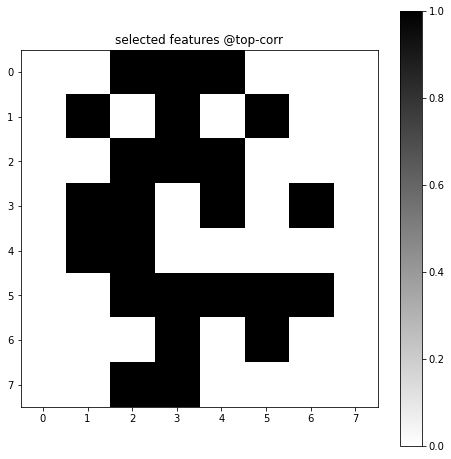

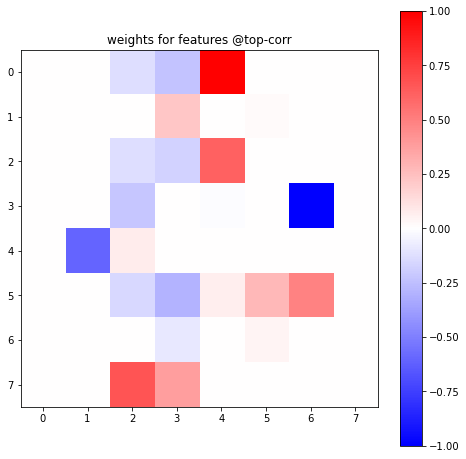

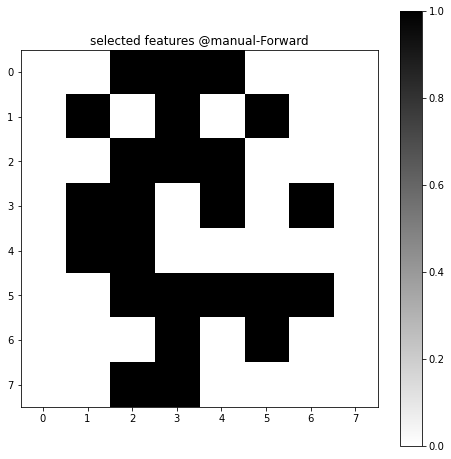

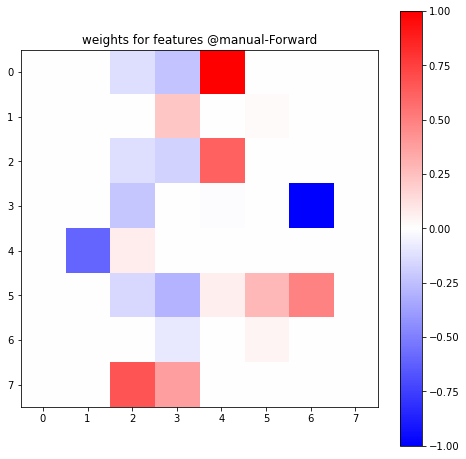

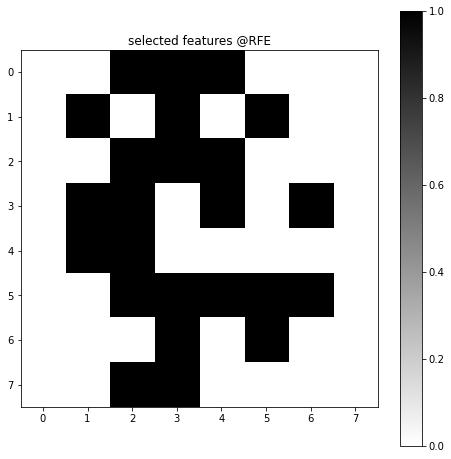

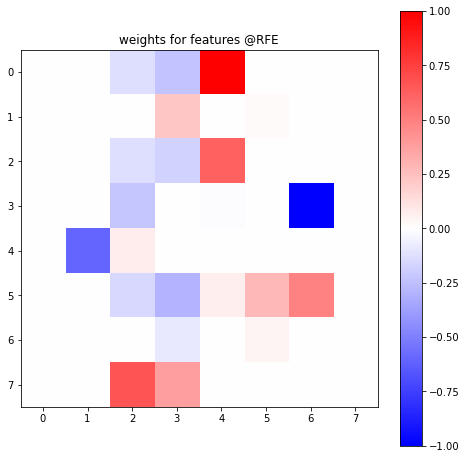

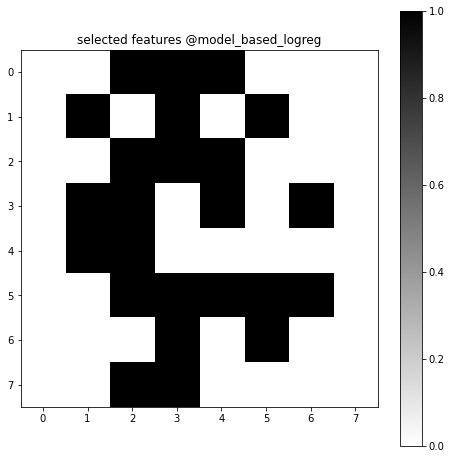

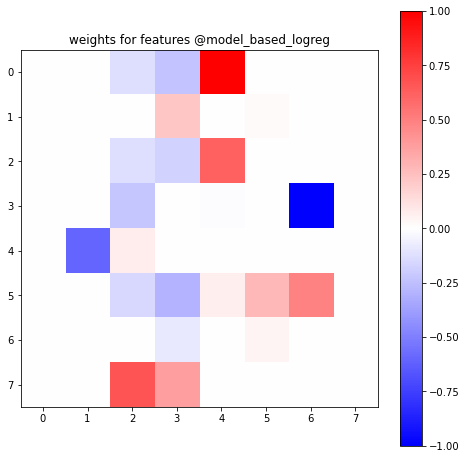

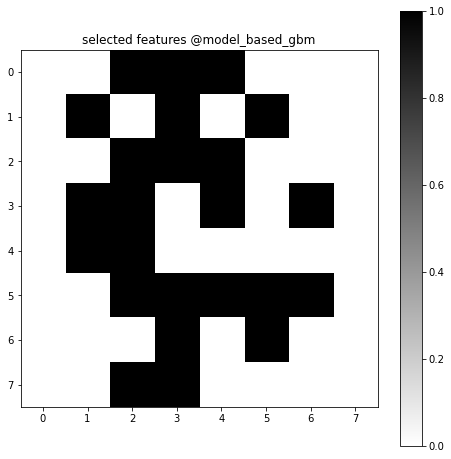

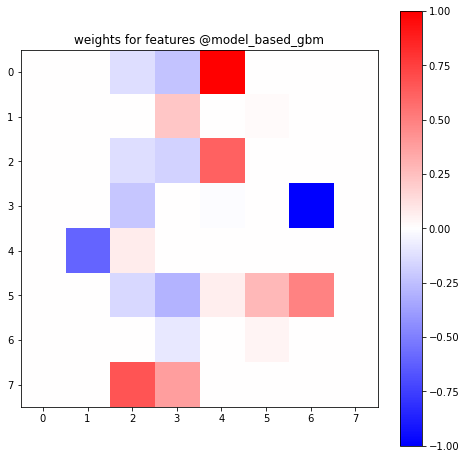

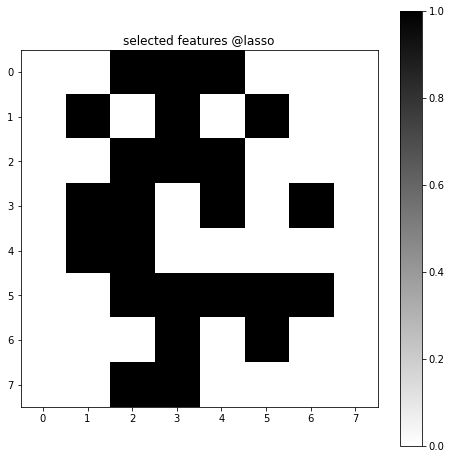

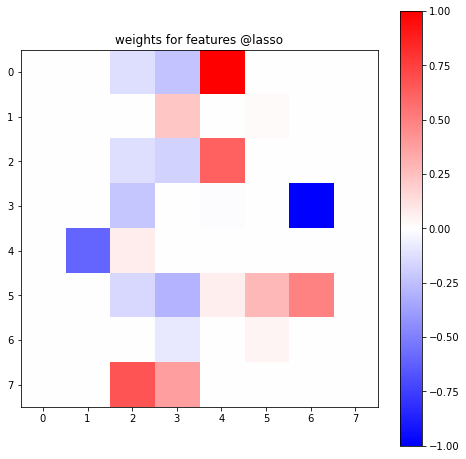

In [56]:
def scale01(s):
        return (s-s.min())/(s.max()-s.min())

for method in methods:
    selected_vars_with_method = summary.loc[methods[0], "features"]
    plt.figure(figsize=(8,8))
    vars64 = np.array([1 if str(item) in selected_vars_with_method else 0 for item in X_train.columns])
    plt.imshow(vars64.reshape(8, 8), cmap='gray_r', vmin=0, vmax=1)
    plt.title(f'selected features @{method}')
    plt.colorbar()
    plt.show()

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train[selected_vars_with_method], y_train)
    all_pixels_weights = pd.DataFrame(index=X_train.columns)
    all_pixels_weights = all_pixels_weights.join(pd.DataFrame(model.coef_[0], index=selected_vars_with_method))
    all_pixels_weights = all_pixels_weights.fillna(0)

    negative_coefs = all_pixels_weights.loc[all_pixels_weights[0]<0]
    scaled_negatives_to_minus1_0 = scale01(negative_coefs)-1
    positive_coefs = all_pixels_weights.loc[all_pixels_weights[0]>0]
    scaled_positives_to_0_1 = scale01(positive_coefs)
    all_pixels_weights['scaled'] = pd.concat([scaled_negatives_to_minus1_0, scaled_positives_to_0_1])
    all_pixels_weights['scaled'] = all_pixels_weights['scaled'].fillna(0)

    all_pixels_weights_array = np.array(all_pixels_weights['scaled'].tolist())
    plt.figure(figsize=(8,8))
    plt.imshow(all_pixels_weights_array.reshape(8, 8), cmap='bwr')
    plt.colorbar()
    plt.title(f'weights for features @{method}')
    plt.show()